# Sheet 6 - Noise and Kurtosis

Team name: DataFun

Members:

Fabian Frank
Jan Botsch
David Munkacsi

## 6.1 ICA

(2, 18000)
(2, 1)
[[ 0.00121829]
 [ 0.01265088]]
(2, 1)
[[ 0.99854594]
 [ 0.99885435]]
(18000,)
(3, 18000)
A=[[ 0.8624976   0.69652282  0.66833603]
 [ 0.2157247   0.55307651  0.43634033]
 [ 0.22680702  0.67115453  0.10410647]]
W_init=[[ 0.09128469  0.30891598  0.40109443]
 [ 0.22963577  0.72348015  0.43509175]
 [ 0.22295033  0.80431097  0.57425524]]

 iter=27625
W final=[[ 0.15564244 -4.16816984  2.8821224 ]
 [ 0.62250788 -0.14481919 -2.82193397]
 [-4.17125481  6.56774393 -1.18878036]]
W_nat final=[[ 1.03412753 -0.86862739 -3.11247282]
 [-0.1644553   4.22722016 -3.33634187]
 [ 3.78164321 -6.08801267  1.10847793]]
ConvSpeed:  (27, 2)


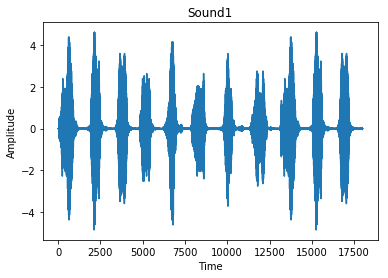

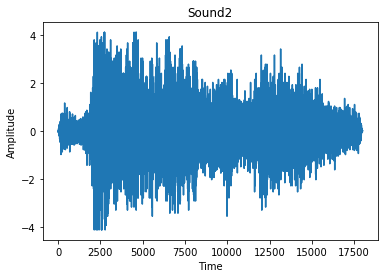

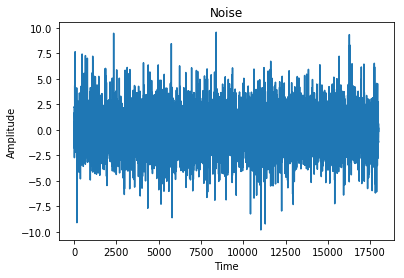

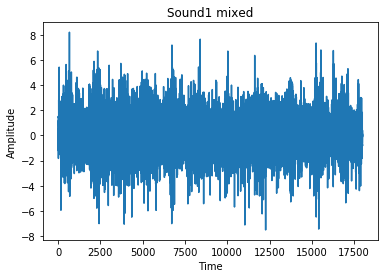

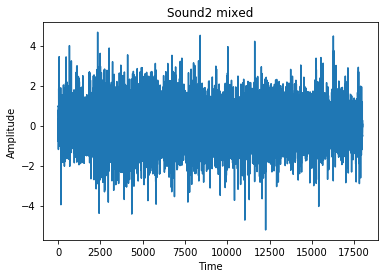

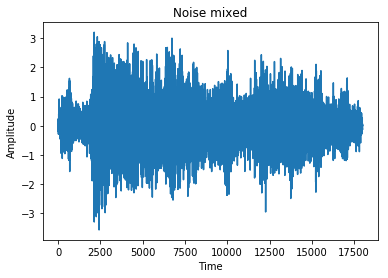

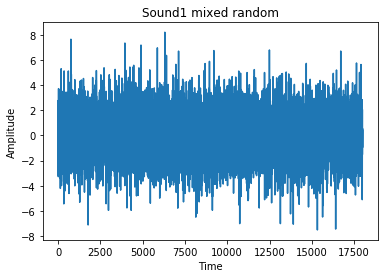

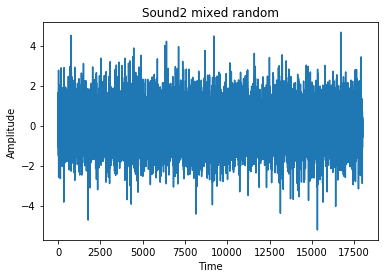

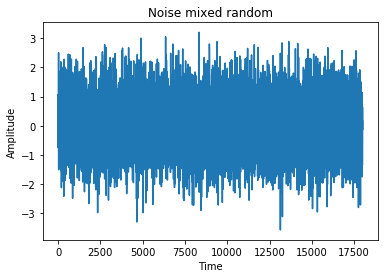

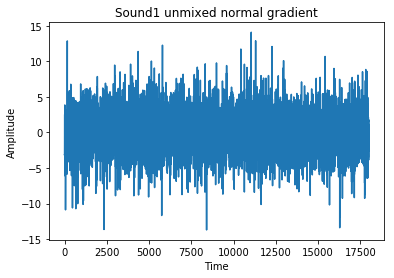

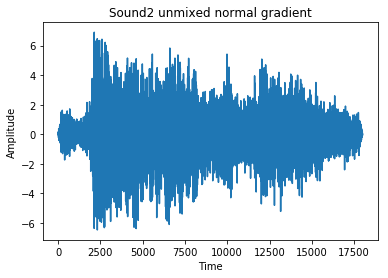

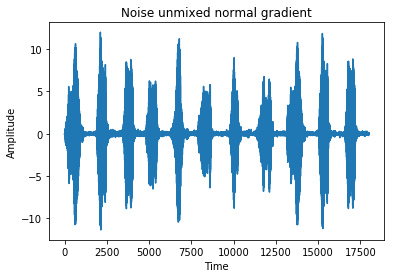

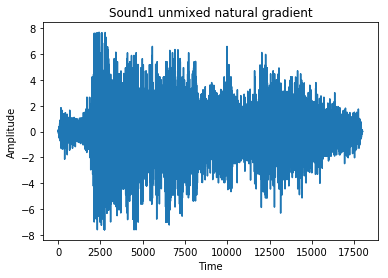

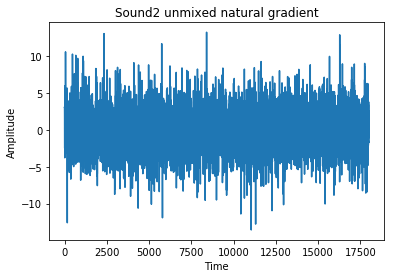

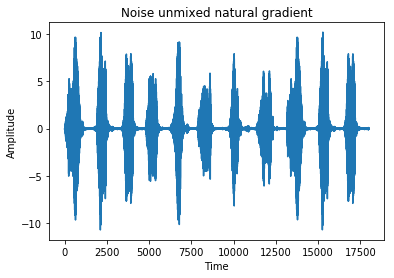

In [1]:
import numpy as np
import matplotlib.pyplot as plt



#defines
samplerate = 8192
N = 3
p = 18000
f_decay = 0.9995

#load the data
dataSet1 = np.loadtxt('./sounds/sound1.dat')
dataSet2 = np.loadtxt('./sounds/sound2.dat')
s = np.stack([dataSet1, dataSet2], axis=0)
print (s.shape)

#create a noise data
mean_data = np.mean(s,axis=1, keepdims=True)
std_data = np.std(s,axis=1, keepdims=True)
print (mean_data.shape)
print (mean_data)
print (std_data.shape)
print (std_data)
dataSet3 = np.random.laplace(0, 1, p);
#dataSet3 = np.random.normal(np.mean(mean_data), np.mean(std_data), p);
print (dataSet3.shape)

s = np.vstack([s, dataSet3])
print (s.shape)


# create random and invertible NxN (2x2) matrix
while True:
    A = np.random.rand(N,N)
    if np.linalg.det(A) != 0.0:
        break
print("A=" + str(A))

#mix the sources
x = np.matmul(A, s)



# remove temporal structure by permutation
x_per = x[:, np.random.permutation(range(0,p))]



#center the permuted data
mean = np.mean(x_per,axis=1, keepdims=True)
x_per_cent = x_per - mean;

#center the non-permuted data
x_cent = x - np.mean(x,axis=1, keepdims=True)


#initialize W at random
while True:
    W_init = np.random.rand(N,N)
    if np.linalg.det(W_init) != 0.0:
        break
W_nat_init = np.copy(W_init)
print("W_init=" + str(W_init))



#function that calculates f''/f'
def stepSigmoid(y):
    return 1 - 2 * (1 / (1 + np.exp(-y)))

#vectorize function
vStepSigmoid = np.vectorize(stepSigmoid)

def perform_ica(x, W, W_nat, eps=0.1):
    #perform ica
    #eps = 0.01
    eps_curr = eps
    convSpeed = np.empty([0,2])
    #for i in range(0,p):
    i=0
    nn = 0;
    while eps_curr > 0.0000001:
        #normal gradient
        dW = np.linalg.inv(W).T + np.outer(vStepSigmoid(np.dot(W,x_per_cent[:,i])),x_per_cent[:,i])
        W = W + eps * dW
        #natural gradient
        unmixed = np.dot(W_nat,x_per_cent[:,i])
        dW_nat = np.dot(np.eye(N) + np.outer(vStepSigmoid(unmixed),unmixed), W_nat)
        W_nat = W_nat + eps_curr * dW_nat
        eps_curr = eps_curr * f_decay
        i = (i+1) % p
        nn = nn +1
        if (i % 1000 == 0):
            convSpeed = np.vstack((convSpeed, [np.sum(W**2), np.sum(W_nat**2)]))

    return (W, W_nat, convSpeed, nn)

W, W_nat, convSpeed, count = perform_ica(x_per, W_init, W_nat_init)
print("\n iter=" + str(count))
print("W final=" + str(W))
print("W_nat final=" + str(W_nat))
print('ConvSpeed: ', convSpeed.shape)

# get the unmixed signals
unmixedNormal = np.matmul(W, x_cent)
unmixedNatural = np.matmul(W_nat, x_cent)



plt.figure()
plt.plot(dataSet1)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1')
plt.figure()
plt.plot(dataSet2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2')
plt.figure()
plt.plot(dataSet3)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Noise')

plt.figure()
plt.plot(x[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 mixed')
plt.figure()
plt.plot(x[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 mixed')
plt.figure()
plt.plot(x[2,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Noise mixed')

plt.figure()
plt.plot(x_per[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 mixed random')
plt.figure()
plt.plot(x_per[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 mixed random')
plt.figure()
plt.plot(x_per[2,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Noise mixed random')

plt.figure()
plt.plot(unmixedNormal[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 unmixed normal gradient')
plt.figure()
plt.plot(unmixedNormal[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 unmixed normal gradient')
plt.figure()
plt.plot(unmixedNormal[2,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Noise unmixed normal gradient')

plt.figure()
plt.plot(unmixedNatural[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 unmixed natural gradient')
plt.figure()
plt.plot(unmixedNatural[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 unmixed natural gradient')
plt.figure()
plt.plot(unmixedNatural[2,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Noise unmixed natural gradient')

plt.show()

## 6.2 Moments of univariate distributions

a) Laplace Distributon

Moment generating function:

$$ M_x(t) = \frac{e^{\mu t}}{1-\sigma^2t^2} $$

First moment (derivating one time and setting t to null)

$$ \dots = \frac{e^{\mu t}(\mu - \mu \sigma^2 t^2 + 2\sigma^2 + t)}{(1-\sigma^2 t^2)^2} \vert_{t=0} = \mu $$

Second moment

$$ \dots = \frac{4 σ^2 t e^{μ t} (μ - μ σ^2 t^2 + 2 σ^2 t))}{(1 - σ^2 t^2)^3} + \frac{e^{μ t} (2 σ^2 - 2 μ σ^2 t)}{(1 - σ^2 t^2)^2} + \frac{μ e^{μ t} (μ - μ σ^2 t^2 + 2 σ^2 t)}{(1 - σ^2 t^2)^2} \vert_{t=0} = 2\sigma^2 $$

Third moment

$$ \dots = \mu + 6\mu\sigma^2 $$

Standardized

$$ \dots = \frac{\mu + 6\mu\sigma^2}{(2\sigma^2)^\frac{3}{2}}$$

Fourth moment

$$ \dots = μ^4 + 12 μ^2 σ^2 + 24 σ^4 $$

Standardized:

$$ \dots = \frac{μ^4}{4\sigma^4} + \frac{3 μ^2}{\sigma^2}  + 6 $$

b) Gauss Distribution
Moment generating function:

$$ M_x(t) = exp(\mu t +\frac{\sigma^2 t^2}{2})$$

We get the 1st moment by derivating the generating function and setting $t$ to $0$

$$ \dots = \mu $$

Second moment (derivating the generating function two times and setting t to zero)

$$ \dots = \mu^2 + \sigma^2 $$

Third moment

$$ \dots = \mu^3 + 3\mu\sigma^2 $$

Standardized:

$$ \dots = \frac{\mu^3 + 3\mu\sigma^2}{(\mu^2 + \sigma^2)^\frac{3}{2}} $$

Fourth moment

$$ \dots = \mu^4 + 6\mu^2\sigma^2 3\sigma^4 $$

Standardized:

$$ \dots = \frac{\mu^4 + 6\mu^2\sigma^2 3\sigma^4}{(\mu^2 + \sigma^2)^2} $$

c) Uniform Distribution

Moment generating function: $$ M_x = E(e^{t x}) = \int_{a}^{b} e^{t x} \frac{1}{b-a} = \frac{1}{b-a} \left[ \frac{e^{t x}}{t}\right]_a^b = \frac{e^{t b} - e^{t a}}{t (b-a)} = \frac{1}{t(b-a)} \left[ bt + \frac{(bt)^2}{2!} + \frac{(bt)^3}{3!} - \left( at + \frac{(at)^2}{2!} + \frac{(at)^3}{3!} \right) \right] = \frac{1}{(b-a)} \left[ b + \frac{b^2 t}{2!} + \frac{b^3 t^2}{3!} - \left( a + \frac{a^2 t}{2!} + \frac{a^3 t^2}{3!} \right) \right] $$ 

We get the 1st moment by derivating $M_x$ one time and setting $t$ to $0$:
$$ \dots = \frac{1}{(b-a)} \left[ \frac{b^2}{2!} - \frac{a^2}{2!} \right] = \frac{b+a}{2} $$

We get the 2nd moment by derivating $M_x$ two times and setting $t$ to $0$:
$$ \dots = \frac{1}{(b-a)} \left[ \frac{b^3}{3} - \frac{a^3}{3} \right] = \frac{b^3-a^3}{3(b-a)} = \frac{b^2 +ba + a^2}{3} $$

We get the 3rd moment by derivating $M_x$ three times and setting $t$ to $0$:
$$ \dots = \frac{1}{(b-a)} \left[ \frac{b^4}{4} - \frac{a^4}{4} \right] = \frac{b^4-a^4}{4(b-a)} $$

Hence the 3rd standardized moment is
$$ \frac{\frac{b^4-a^4}{4(b-a)}}{\left(\frac{b^3-a^3}{3(b-a)}\right)^{\frac{3}{2}}} = \frac{b^4-a^4}{4(b-a)} \left(\frac{3(b-a)}{b^3-a^3}\right)^{\frac{2}{3}}  $$

We get the 4th moment by derivating $M_x$ four times and setting $t$ to $0$:
$$ \dots = \frac{1}{(b-a)} \left[ \frac{b^5}{5} - \frac{a^5}{5} \right] = \frac{b^5-a^5}{5(b-a)} $$

Hence the 3rd standardized moment is
$$ \frac{\frac{b^5-a^5}{5(b-a)}}{\left(\frac{b^3-a^3}{3(b-a)}\right)^{\frac{4}{2}}} = \frac{b^5-a^5}{5(b-a)} \left(\frac{3(b-a)}{b^3-a^3}\right)^{2} = \frac{9 (b^5-a^5) (b-a)}{5 (b^3-a^3)^2}  $$

| | Laplace $(\mu,b)$ | Gauss $(\mu,\sigma)$ | Uniform $(a,b)$ |
| ------------- |:-------------:| :-------------:|:-------------:|
| mean: first moment $\langle X \rangle$ | $$\mu$$ | $$ \mu $$ | $\frac{b+a}{2}$ |
| variance: second centered moment $\langle X \rangle^2_c$ | $$ 2\sigma^2$$ | $$ \mu + \sigma $$ |$\frac{b^2 +ba + a^2}{3}$ |
| skewness: third standardized moment $\langle X \rangle^3_s$ | $\frac{\mu + 6\mu\sigma^2}{(2\sigma^2)^\frac{3}{2}}$| $$ \frac{\mu^3 + 3\mu\sigma^2}{(\mu^2 + \sigma^2)^\frac{3}{2}} $$ | $\frac{b^4-a^4}{4(b-a)} \left(\frac{3(b-a)}{b^3-a^3}\right)^{\frac{2}{3}}$ |
| kurtosis: fourth standardized moment $\langle X \rangle^4_s$ | $ \frac{μ^4}{4\sigma^4} + \frac{3 μ^2}{\sigma^2}  + 6 $ | $$\frac{\mu^4 + 6\mu^2\sigma^2 3\sigma^4}{(\mu^2 + \sigma^2)^2}$$| $\frac{9 (b^5-a^5) (b-a)}{5 (b^3-a^3)^2}$ |

$$ \langle X^i \rangle_c = \langle(X-\langle X \rangle)^i\rangle $$
$$ \langle X^i \rangle_s = \frac{\langle X^i \rangle_c}{\langle X^2 \rangle^{i/2}_c}$$ 

## 6.3 Kurtosis

Normal


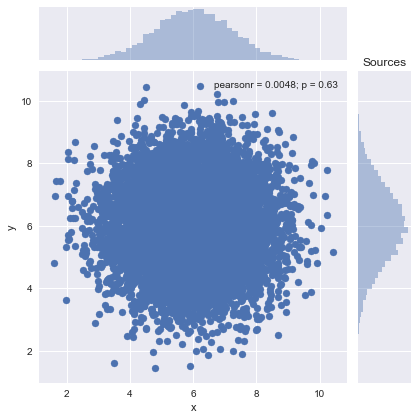

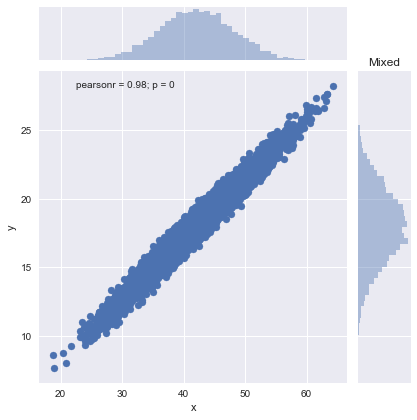

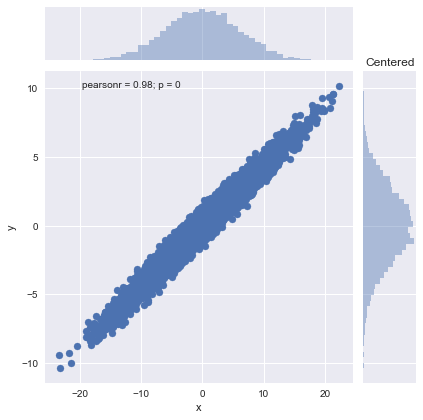

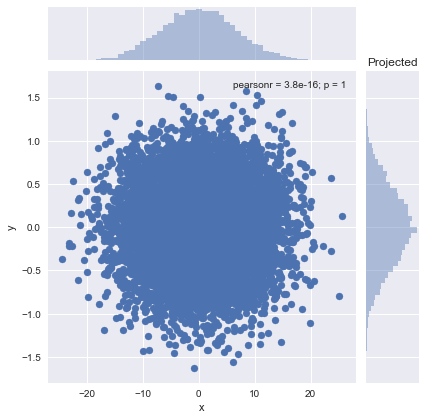

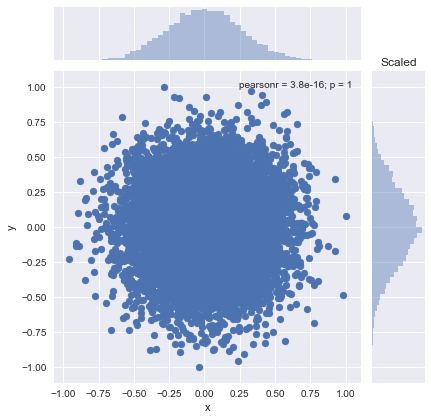

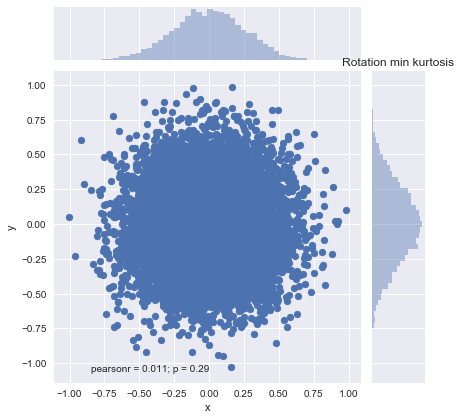

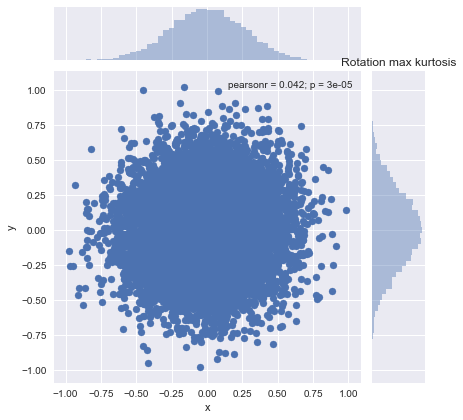

Uniform


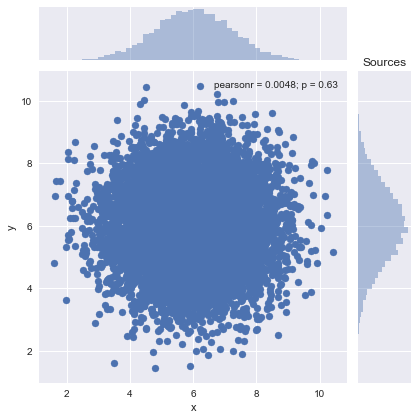

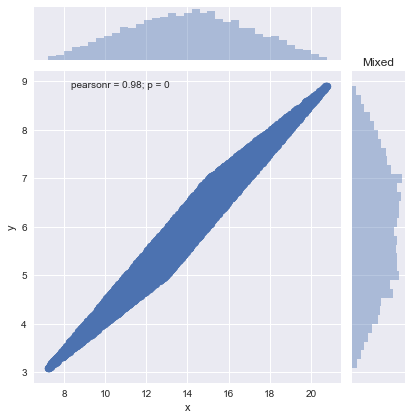

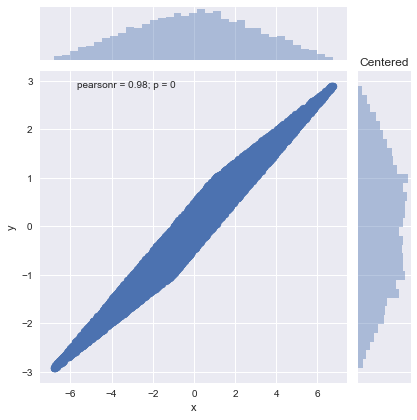

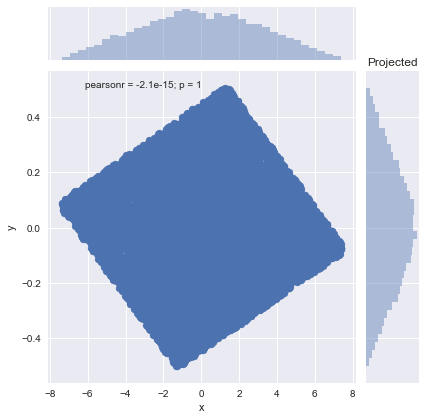

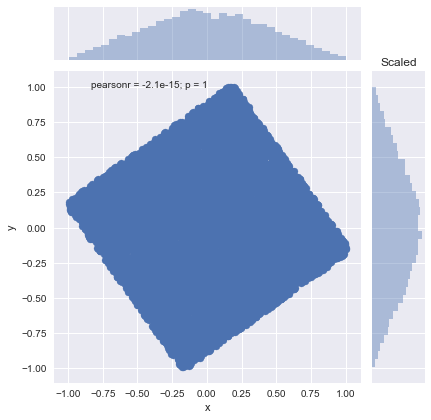

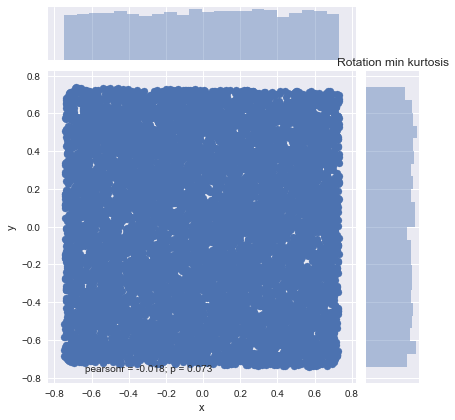

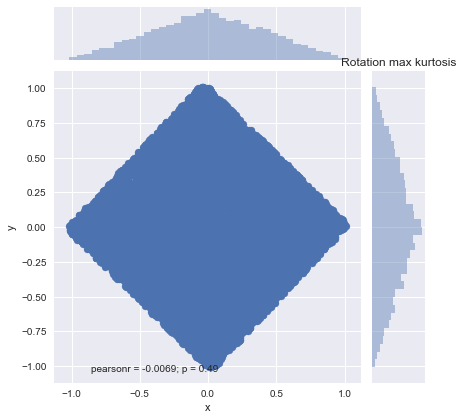

Laplacian


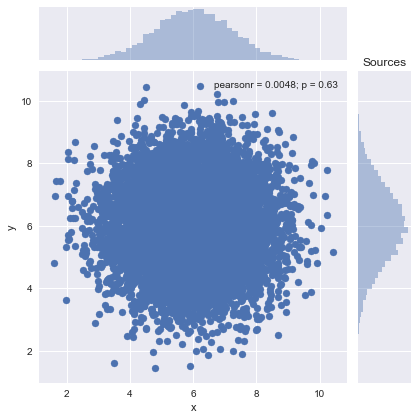

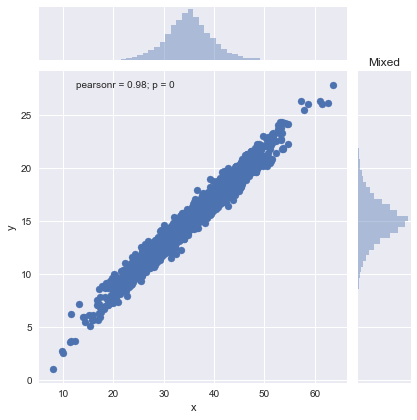

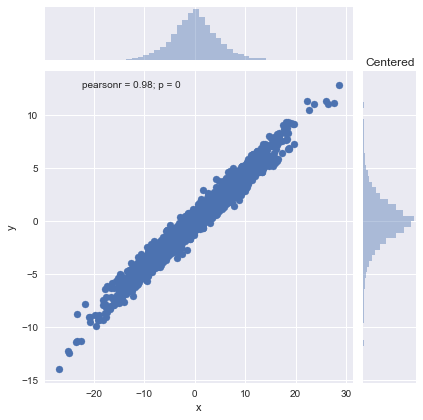

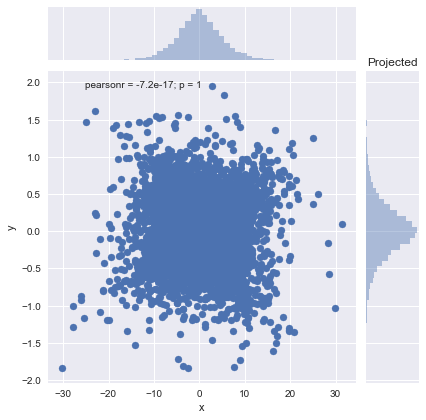

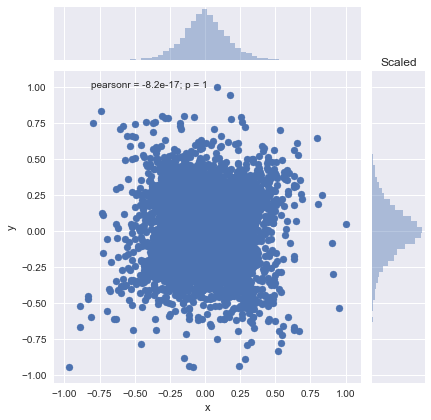

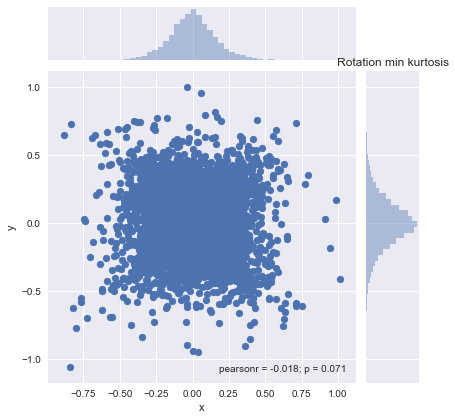

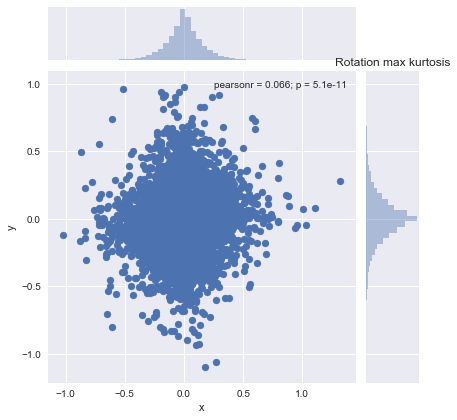

In [3]:
import numpy as np
import scipy as scipy
import scipy.io as io
from sklearn.decomposition import PCA
from sklearn import preprocessing as pre
import math
import matplotlib.pyplot as plt
import seaborn as sea
import pandas as pd

#load data from mat file
distrib = io.loadmat("distrib.mat")

normal = distrib.get("normal")
uniform = distrib.get("uniform")
laplacian = distrib.get("laplacian")

# a) apply mixing
def mix(x):
    A = np.asarray([[4,3],[2,1]])
    return np.dot(A,x)

# b) center to zero mean 
def center(x):
    return x - x.mean(axis=1, keepdims=True)

# c) apply PCA and project data onto PC
def applyPCA(x):
    pca = PCA()
    pca.fit(x)
    return pca.transform(x)

# d) scale data to unit variance
def scale(x):
    return pre.maxabs_scale(x)

# e rotate data
def rotate(x, angle): # x of shape (2,n)
    R = np.asarray([[math.cos(angle), -math.sin(angle)],[math.sin(angle), math.cos(angle)]])
    return np.dot(R, x)

def rotateAndGetKurtosis(x, angle):
    scaledRot = rotate(x.T, angle).T
    kurt = scipy.stats.kurtosis(scaledRot)    
    #print("kurt: ", kurt)
    return kurt

def findMinAndMaxKurt(x, angles):
    kurts = np.empty((angles.shape[0],2))
    idx = 0
    for angle in angles:
        kurt = rotateAndGetKurtosis(x, angle)
        kurts[idx] = kurt
        idx += 1
    
    maxIdx = np.argmax(kurts[:,0])
    minIdx = np.argmin(kurts[:,1])
    return maxIdx, minIdx

def plotdata(source, mixed, centered, projected, scaled, rotMin, rotMax):    
    # Plotting the results.
 
    df = pd.DataFrame(source, columns=["x", "y"])
    sea.jointplot(x="x", y="y", data=df)
    plt.title('Sources')
    
    df = pd.DataFrame(mixed, columns=["x", "y"])
    sea.jointplot(x="x", y="y", data=df)
    plt.title('Mixed')
    
    df = pd.DataFrame(centered, columns=["x", "y"])
    sea.jointplot(x="x", y="y", data=df)
    plt.title('Centered')
    
    df = pd.DataFrame(projected, columns=["x", "y"])
    sea.jointplot(x="x", y="y", data=df)
    plt.title('Projected')
    
    df = pd.DataFrame(scaled, columns=["x", "y"])
    sea.jointplot(x="x", y="y", data=df)
    plt.title('Scaled')
    
    df = pd.DataFrame(rotMin, columns=["x", "y"])
    sea.jointplot(x="x", y="y", data=df)
    plt.title('Rotation min kurtosis')
    
    df = pd.DataFrame(rotMax, columns=["x", "y"])
    sea.jointplot(x="x", y="y", data=df)
    plt.title('Rotation max kurtosis')

def runExercise(x):
    xNormal = mix(x)
    xNormalCentered = center(xNormal)
    # transpose data for further processing
    xNormalCentered = xNormalCentered.T
    
    projectedNormalCentered = applyPCA(xNormalCentered)
    scaledNormal = scale(projectedNormalCentered)
    
    angles = np.arange(0, 2, 1/50)
    angles = angles * math.pi
    maxIdx, minIdx = findMinAndMaxKurt(scaledNormal, angles)
    
    rotNormMax = rotate(scaledNormal.T, angles[maxIdx])
    rotNormMin = rotate(scaledNormal.T, angles[minIdx])
    
    plotdata(normal.T, xNormal.T, xNormalCentered, projectedNormalCentered, scaledNormal, rotNormMin.T, rotNormMax.T)
    plt.show()

print("Normal")
runExercise(normal)
print("Uniform")
runExercise(uniform)
print("Laplacian")
runExercise(laplacian)